In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os
import pandas as pd
import seaborn as sns
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# 원본 데이터 경로
original_dataset_dir = '/content/gdrive/My Drive/deeplearning/project/original'

# 클래스 list
classes_list = os.listdir(original_dataset_dir)

# split한 데이터를 저장할 디렉토리 지정 후 생성
base_dir = '/content/gdrive/My Drive/deeplearning/project/data_split'
os.mkdir(base_dir)

# train/validation/test 하위 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


for cls in classes_list:
    # train 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(train_dir, cls))
    
    # validation 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(validation_dir, cls))
    
    # test 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(test_dir, cls))

FileExistsError: ignored

In [ ]:
import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
    # 데이터 나눌 비율 지정 (6:2:2)
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

In [3]:
# Directories
train_directory = "/content/gdrive/My Drive/deeplearning/project/data_split/train"
valid_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/validation"
test_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/test"
# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 10
batch_size = 16
num_of_classes = 52
num_of_train_samples = 473
num_of_valid_samples = 146
num_of_test_samples = 146


# Load Train Data as image generator with Keras, Normalization with (rescale=1./255)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Validation Data as image generator with Keras, Normalization with (rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                        class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                         shuffle=True)

# Load Test Data as image generator with Keras, Normalization with (rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_directory, 
                                                                        class_mode='categorical', 
                                                                        batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                        shuffle=False)

Found 473 images belonging to 52 classes.
Found 146 images belonging to 52 classes.
Found 146 images belonging to 52 classes.


In [4]:
# Get VGG-16 Model
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=52, activation='softmax')(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model



In [5]:
def trainModelAndGetConfusionMatrix(model):
  # Fit the model
  model.fit_generator(train_generator,
                      epochs=epochs,
                      steps_per_epoch=num_of_train_samples // batch_size,
                      validation_data=valid_generator,
                      validation_steps=num_of_valid_samples // batch_size)

  # Evaluate the model
  loss_and_metrics = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  print("Test Loss: ", loss_and_metrics[0])
  print("Test Accuracy: ", loss_and_metrics[1])
  test_generator.reset()

  return model

In [ ]:
# Y_pred = model.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)
#   y_pred = np.argmax(Y_pred, axis=1)

#   class_names = []
#   for key in train_generator.class_indices:
#       class_names.append(key)

#   cr = classification_report(test_generator.classes, y_pred, target_names=class_names)
#   print("Classification Report\n" + cr) # Print classification report
#   cm = confusion_matrix(test_generator.classes, y_pred)

#   plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
#   plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')

In [6]:
# Get VGG-16 Model with lastFourTrainable=False
vgg_model_a = getVGG16Model(lastFourTrainable=False)
# Train VGG-16 Model and get Confusion Matrix
vgg_model_b = trainModelAndGetConfusionMatrix(vgg_model_b)
vgg_model_a.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')



KeyboardInterrupt: ignored

In [ ]:
# Get VGG-16 Model with lastFourTrainable=True
vgg_model_b = getVGG16Model(lastFourTrainable=True)
# Train VGG-16 Model and get Confusion Matrix
vgg_model_b = trainModelAndGetConfusionMatrix(vgg_model_b)
vgg_model_b.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')

In [ ]:
# Get ResNet-50 Model
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=10, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True

  # Compile ResNet-50 model
  resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()
  
  return resnet_model

In [ ]:

# # Get ResNet-50 Model with lastFourTrainable=False
# resnet_model_a = getResNet50Model(lastFourTrainable=False)
# # Train ResNet-50 Model and get Confusion Matrix
# resnet_model_a = trainModelAndGetConfusionMatrix(resnet_model_a)
# resnet_model_a.save_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')

In [ ]:
# # Get ResNet-50 Model with lastFourTrainable=True
# resnet_model_b = getResNet50Model(lastFourTrainable=True)
# # Train ResNet-50 Model and get Confusion Matrix
# resnet_model_b = trainModelAndGetConfusionMatrix(resnet_model_b)
# resnet_model_b.save_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')

In [7]:
# Get feature vector of an image by given model and img_path
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector


# Get cosine similarity between feature vectors A and B using cosine similarity
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity[0][0]


# Function for get dataframe which contains the output features of given model
def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  train_files = train_generator.filepaths
  #valid_files = valid_generator.filepaths
  files = train_files #+ valid_files

  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 

  print("All files added.")
  return df

# Plot similar 5 images with given image and similar images dataframe
def plotSimilarImages(img_file, similar_df, model_name):
  img = cv2.imread(img_file)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  split_list = img_file.split('/')
  split_list.reverse()
  img_class = split_list[1]
  fig, axarr = plt.subplots(2,3)
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + model_name + "\nClass: " + img_class)
  axarr[0,0].axis('off')

  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    filepath = sim['file']
    similarity = sim['similarity']
    split_list = filepath.split('/')
    split_list.reverse()
    sim_class = split_list[1]

    similar = cv2.imread(filepath)
    similar = cv2.resize(similar, (224, 224))
    similar = cv2.cvtColor(similar, cv2.COLOR_BGR2RGB)
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + sim_class)
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()



# Get and plot 5 similar images for given image path and features dataframe
def getSimilarImages(img_file, features_df, model, model_name):
  img_features = getFeatureVector(model, img_file)
  features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features, np.asarray(row['features'])), axis=1)  
  sorted_df = features_df.sort_values(by='similarity', ascending=False)  
  plotSimilarImages(img_file, sorted_df.head(5), model_name) #head(5)를 조절하여 순위 결정

In [8]:

# Get feature extractor model from last layer of vgg_model_a
vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('new_fc').output)

df = getFeatureDataFrame(feature_model_vgg_a)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_a.pickle")

vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('new_fc').output)

df = getFeatureDataFrame(feature_model_vgg_b)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_b.pickle")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

KeyboardInterrupt: ignored

In [ ]:
# resnet_model_a = getResNet50Model(lastFourTrainable=False)
# resnet_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')
# feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

# df = getFeatureDataFrame(feature_model_resnet_a)
# df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_resnet_a.pickle")


# # Get feature extractor model from last layer of resnet_model_b
# resnet_model_b = getResNet50Model(lastFourTrainable=True)
# resnet_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')
# feature_model_resnet_b = Model(inputs=resnet_model_b.input, outputs=resnet_model_b.get_layer('new_fc').output)

# df = getFeatureDataFrame(feature_model_resnet_b)
# df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_resnet_b.pickle")






In [9]:
# Test images path
feature_test_path = '/content/gdrive/My Drive/deeplearning/project/feature_test'
feature_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=feature_test_path,
                                                                  class_mode='categorical',
                                                                  batch_size=batch_size,
                                                                  target_size=(img_rows, img_cols),
                                                                  color_mode="rgb",
                                                                  shuffle=False)
feature_test_files = feature_test_generator.filepaths

Found 3 images belonging to 3 classes.


In [ ]:
# test_img = '/content/gdrive/My Drive/deeplearning/project/data_split/test/63빌딩/000015.jpg'
# imgg = cv2.imread(test_img,cv2.IMREAD_COLOR)
# getSimilarImages(imgg, df, feature_model_vgg_a, 'VGG-16_a')

In [16]:
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum-eco.
(Reading database ... 160724 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


FileNotFoundError: ignored

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s

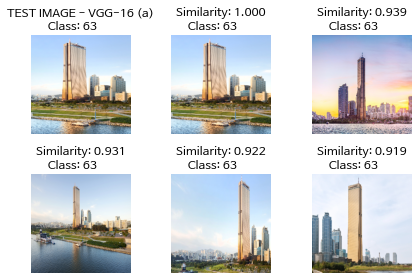

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4458 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s

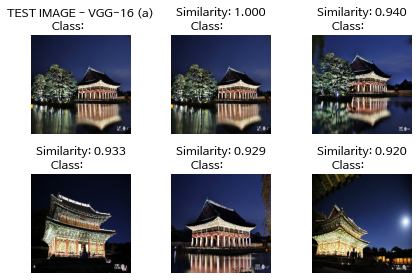

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0, flags=flags)


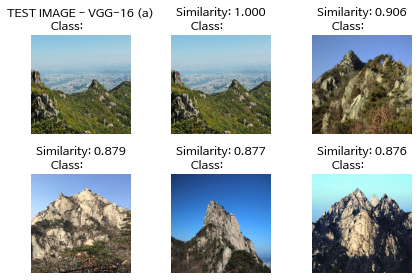

In [14]:
# Get similar images of test images for VGG-16 (a)
vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_a.pickle')


for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_a, 'VGG-16 (a)')



In [ ]:
# Get similar images of test images for VGG-16 (b)
vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_b.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_b, 'VGG-16 (b)')

In [ ]:
# Get similar images of test images for ResNet-50 (a)
resnet_model_a = getResNet50Model(lastFourTrainable=False)
resnet_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')
feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_resnet_a.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_resnet_a, 'ResNet-50 (a)')

In [ ]:
# Get similar images of test images for ResNet-50 (b)
resnet_model_b = getResNet50Model(lastFourTrainable=True)
resnet_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')
feature_model_resnet_b = Model(inputs=resnet_model_b.input, outputs=resnet_model_b.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_resnet_b.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_resnet_b, 'ResNet-50 (b)')